# Importation des bibliothéques

In [33]:
import pandas as pd
import glob

# Lecture des fichiers du dossier graph G99

In [34]:
!ls /data/bd/dataset/proteine/80_80/G99

components.parquet		graph_nodeID_only_partitionned_200
graph				graph_partition_by_query_id
graph_deduplicated2		graph_partitionned
graph_nodeID_only		graph_removed
graph_nodeID_only_component	graph_with_components
graph_nodeID_only_partitionned	node_with_comp_and_annotation


In [35]:
parquet_folder = "/data/bd/dataset/proteine/80_80/G99/graph/"

# Lire tous les fichiers Parquet dans une liste de DataFrames
dfs = [pd.read_parquet(fichier) for fichier in glob.glob(parquet_folder + '*.parquet')]

# Concaténer les DataFrames en un seul DataFrame
df = pd.concat(dfs, ignore_index=True)

# Afficher les premières lignes du DataFrame
df.head()

,query_id,query_length,target_id,target_length,match_length,percent_identity,e_value,relative_sim
0,40910035:3,86,30648403:2,1486,86,100.0,1.300000e-38,1.0
1,40910035:3,86,40725366:3,484,86,100.0,1.300000e-38,1.0
2,40910035:3,86,40725367:5,323,86,100.0,1.300000e-38,1.0
3,40910035:3,86,40787900:2,368,86,100.0,1.300000e-38,1.0
4,40910042:0,149,103459895:5,69,69,100.0,1.500000e-28,1.0


In [36]:
df = df[['target_id', 'query_id']]
df.shape

(359798439, 2)

# On varie le degree de parallélisme (num_partition)

In [11]:
degree_parallelisme = [10,20, 30, 40, 50, 60]

for d in degree_parallelisme :
    print("degree de parallélisme : ",d)
    new_df = df
    # Ajout d'une nouvelle colonne 'partition' basée sur le modulo de target_id
    new_df['partition'] = new_df['target_id'].apply(lambda x: hash(x) % d)
    partition_freq = new_df.groupby('partition').size().reset_index(name='count')
    
    partitions = partition_freq['partition'].unique()
    for partition in partitions:
        df_partition = new_df[new_df['partition'] == partition]
        file_path = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/{d}_partitions/partition_{partition}.parquet"
        df_partition.to_parquet(file_path, index=False, engine='pyarrow')
    

degree de parallélisme :  10
degree de parallélisme :  20
degree de parallélisme :  30
degree de parallélisme :  40
degree de parallélisme :  50
degree de parallélisme :  60


In [10]:
! ls /data/bd/dataset/proteine/80_80/G99/graph_partitionned

10_partitions  30_partitions  50_partitions
20_partitions  40_partitions  60_partitions


## Nombre de noeuds par partition selon le nombre de partitions choisi : 

In [25]:

# Fonction pour concaténer les listes de chaque ligne
def concat_lists(row):
    return row['target_id'] + row['query_id']


# Afficher les premières lignes du nouveau DataFrame
aggregated_df.head()

,partition,target_id,query_id,nombre_de_noeuds_ditincts
0,0,"[103459895:5, 40739982:2, 40227380:0, 58427391...","[40910042:0, 40910052:1, 40910094:0, 40910141:...",8925220
1,1,"[146399187:3, 147965653:0, 93108247:4, 1435401...","[40910042:0, 40910042:0, 40910042:0, 40910042:...",8927575
2,2,"[4374326:0, 137538873:3, 73805081:0, 1383828:1...","[40910042:0, 40910042:0, 40910049:2, 40910094:...",8923305
3,3,"[1365595:5, TARA_AOS_82_MAG_00186_000000000601...","[40910094:0, 40910147:1, 40910194:3, 40910194:...",8926643
4,4,"[40725366:3, 106359663:3, 40798112:0, 48074368...","[40910035:3, 40910194:3, 40910194:3, 40910194:...",8925794


In [26]:
np.mean(aggregated_df['nombre_de_noeuds_ditincts'])

8925988.3

degree de parallélisme :  10
degree de parallélisme :  20
degree de parallélisme :  30
degree de parallélisme :  40
degree de parallélisme :  50
degree de parallélisme :  60


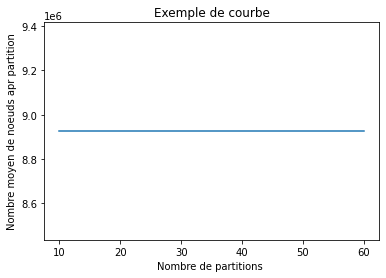

In [27]:
import numpy as np 
import matplotlib.pyplot as plt

    
def nombre_noeuds_distincts(row):
    return len(set(row['target_id']+ row['query_id']))

degree_parallelisme = [10,20, 30, 40, 50, 60]
nb_noeuds = []
for d in degree_parallelisme :
    print("degree de parallélisme : ",d)
    new_df = df
    # Ajout d'une nouvelle colonne 'partition' basée sur le modulo de target_id
    new_df['partition'] = new_df['target_id'].apply(lambda x: hash(x) % d)

    # Grouper les données par 'partition' et agréger les autres colonnes sous forme de listes
    aggregated_df = df.groupby('partition').agg(lambda x: x.tolist()).reset_index()


    # Appliquer la fonction à chaque ligne
    # aggregated_df['concatenated_lists'] = aggregated_df.apply(concat_lists, axis=1)
    aggregated_df['nombre_de_noeuds_ditincts'] = aggregated_df.apply(nombre_noeuds_distincts, axis=1)

    nb_noeuds.append(np.mean(aggregated_df['nombre_de_noeuds_ditincts']))
    
# Tracer la courbe
plt.plot(degree_parallelisme, nb_noeuds)

# Ajouter un titre et des étiquettes d'axe
plt.title('Exemple de courbe')
plt.xlabel('Nombre de partitions ')
plt.ylabel('Nombre moyen de noeuds apr partition')

# Afficher la courbe
plt.show()



degree de parallélisme :  10
degree de parallélisme :  20
degree de parallélisme :  30
degree de parallélisme :  40
degree de parallélisme :  50
degree de parallélisme :  60


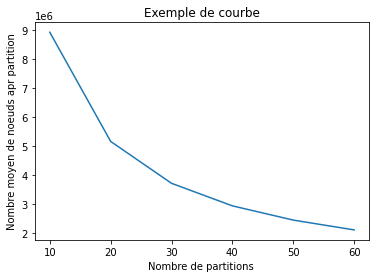

In [37]:
import numpy as np 
import matplotlib.pyplot as plt

    
def nombre_noeuds_distincts(row):
    return len(set(row['target_id']+ row['query_id']))

degree_parallelisme = [10,20, 30, 40, 50, 60]
nb_noeuds = []
for d in degree_parallelisme :
    print("degree de parallélisme : ",d)
    new_df = df
    # Ajout d'une nouvelle colonne 'partition' basée sur le modulo de target_id
    new_df['partition'] = new_df['target_id'].apply(lambda x: hash(x) % d)

    # Grouper les données par 'partition' et agréger les autres colonnes sous forme de listes
    aggregated_df = df.groupby('partition').agg(lambda x: x.tolist()).reset_index()


    # Appliquer la fonction à chaque ligne
    # aggregated_df['concatenated_lists'] = aggregated_df.apply(concat_lists, axis=1)
    aggregated_df['nombre_de_noeuds_ditincts'] = aggregated_df.apply(nombre_noeuds_distincts, axis=1)

    nb_noeuds.append(np.mean(aggregated_df['nombre_de_noeuds_ditincts']))
    
# Tracer la courbe
plt.plot(degree_parallelisme, nb_noeuds)

# Ajouter un titre et des étiquettes d'axe
plt.title('Exemple de courbe')
plt.xlabel('Nombre de partitions ')
plt.ylabel('Nombre moyen de noeuds apr partition')

# Afficher la courbe
plt.show()

